In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from scipy.stats import chi2_contingency

In [98]:
filepath = "C:/Users/trfit/OneDrive/Documents/learning/UC/cmi_project/cmi-detect-behavior-with-sensor-data/"

df_test = pd.read_csv(filepath+"test.csv")
df_test_demo = pd.read_csv(filepath+"test_demographics.csv")
df_train = pd.read_csv(filepath+"train.csv")
df_train_demo = pd.read_csv(filepath+"train_demographics.csv")
dfs = [df_test,df_test_demo,df_train,df_train_demo]

# Explore:
- [X] dataset size (features and data points)
- [X] data types (data types and categories listed below)
- [X] missing data? (appears to be no missing data)
- [X] object histogram
- [X] object crossplots
- [ ] range and outlier data for numerical data

# Data Notes:
- These columns are in train, but not test: sequence_type, orientation, behavior, phase, gesture
- train samples: 574,945, test samples: 107
- train_demo: 81, test_demo: 2
- train demo subjects are only found in training data. test demo subjects are only found in test data.
- Train:
  - float64(332), int64(1), object(8)
  - objects: row_id, sequence_type, sequence_id, subject, orientation, behavior, phase, gesture

- Since it is time series data, order of operations or sequence is important.
- The proximity sensors lend themselves to a CNN model. I wonder if we could classify the object proximity.

## Categorical Data

number of unique values per object col:
- row_id: all are unique
- sequence_type: 2 ['Target', 'Non-Target']
- sequence_id: 8151 [SEQ_######]
- subject: 81
- orientation: 4 ['Seated Lean Non Dom - FACE DOWN', 'Lie on Side - Non Dominant',
       'Seated Straight', 'Lie on Back']
- behavior: 4 ['Relaxes and moves hand to target location', 'Hand at target location', 'Performs gesture', 'Moves hand to target location']
- phase: 2 ['Transition', 'Gesture']
- gesture: 18 ['Cheek - pinch skin', 'Forehead - pull hairline',
       'Write name on leg', 'Feel around in tray and pull out an object',
       'Neck - scratch', 'Neck - pinch skin', 'Eyelash - pull hair',
       'Eyebrow - pull hair', 'Forehead - scratch',
       'Above ear - pull hair', 'Wave hello', 'Write name in air',
       'Text on phone', 'Pull air toward your face',
       'Pinch knee/leg skin', 'Scratch knee/leg skin',
       'Drink from bottle/cup', 'Glasses on/off']

# Model Ideas:

- Need something to process the proximity sensors, CNN model?

In [58]:
"""
Object dataframe capture (8): df_train[['row_id','sequence_type','sequence_id','subject','orientation','behavior','phase','gesture']].head()

Measure linear acceleration meters per second squared from the IMU sensor (3): 
    df_train[['acc_x', 'acc_y', 'acc_z']]
Orientation data which combines information from the IMU's gyroscope, accelerometer, and magnetometer to describe the device's orientation in 
3D space. (4): 
    df_train[['rot_w', 'rot_x', 'rot_y', 'rot_z']]
There are five thermopile sensors on the watch which record temperature in degrees Celsius. (5)
    df_train[['thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5']]
There are five time-of-flight sensors on the watch that measure distance. In the dataset, the 0th pixel for the first time-of-flight sensor can 
be found with column name tof_1_v0, whereas the final pixel in the grid can be found under column tof_1_v63. This data is collected row-wise, where 
the first pixel could be considered in the top-left of the grid, with the second to its right, ultimately wrapping so the final value is in the 
bottom right (see image above). The particular time-of-flight sensor is denoted by the number at the start of the column name (e.g., 1_v0 is the 
first pixel for the first time-of-flight sensor while 5_v0 is the first pixel for the fifth time-of-flight sensor). If there is no sensor response 
(e.g., if there is no nearby object causing a signal reflection), a -1 is present in this field. Units are uncalibrated sensor values in the range 
0-254. Each sensor contains 64 pixels arranged in an 8x8 grid, visualized in the figure below. (320)
    sensor_num = "1"
    df_train[['tof_'+sensor_num+'_v0', 'tof_'+sensor_num+'_v1', 'tof_'+sensor_num+'_v2', 'tof_'+sensor_num+'_v3', 'tof_'+sensor_num+'_v4', 
              'tof_'+sensor_num+'_v5', 'tof_'+sensor_num+'_v6', 'tof_'+sensor_num+'_v7', 'tof_'+sensor_num+'_v8', 'tof_'+sensor_num+'_v9', 
              'tof_'+sensor_num+'_v10', 'tof_'+sensor_num+'_v11', 'tof_'+sensor_num+'_v12', 'tof_'+sensor_num+'_v13', 'tof_'+sensor_num+'_v14', 
              'tof_'+sensor_num+'_v15', 'tof_'+sensor_num+'_v16', 'tof_'+sensor_num+'_v17', 'tof_'+sensor_num+'_v18', 'tof_'+sensor_num+'_v19', 
              'tof_'+sensor_num+'_v20', 'tof_'+sensor_num+'_v21', 'tof_'+sensor_num+'_v22', 'tof_'+sensor_num+'_v23', 'tof_'+sensor_num+'_v24', 
              'tof_'+sensor_num+'_v25', 'tof_'+sensor_num+'_v26', 'tof_'+sensor_num+'_v27', 'tof_'+sensor_num+'_v28', 'tof_'+sensor_num+'_v29', 
              'tof_'+sensor_num+'_v30', 'tof_'+sensor_num+'_v31', 'tof_'+sensor_num+'_v32', 'tof_'+sensor_num+'_v33', 'tof_'+sensor_num+'_v34', 
              'tof_'+sensor_num+'_v35', 'tof_'+sensor_num+'_v36', 'tof_'+sensor_num+'_v37', 'tof_'+sensor_num+'_v38', 'tof_'+sensor_num+'_v39', 
              'tof_'+sensor_num+'_v40', 'tof_'+sensor_num+'_v41', 'tof_'+sensor_num+'_v42', 'tof_'+sensor_num+'_v43', 'tof_'+sensor_num+'_v44', 
              'tof_'+sensor_num+'_v45', 'tof_'+sensor_num+'_v46', 'tof_'+sensor_num+'_v47', 'tof_'+sensor_num+'_v48', 'tof_'+sensor_num+'_v49', 
              'tof_'+sensor_num+'_v50', 'tof_'+sensor_num+'_v51', 'tof_'+sensor_num+'_v52', 'tof_'+sensor_num+'_v53', 'tof_'+sensor_num+'_v54', 
              'tof_'+sensor_num+'_v55', 'tof_'+sensor_num+'_v56', 'tof_'+sensor_num+'_v57', 'tof_'+sensor_num+'_v58', 'tof_'+sensor_num+'_v59', 
              'tof_'+sensor_num+'_v60', 'tof_'+sensor_num+'_v61', 'tof_'+sensor_num+'_v62', 'tof_'+sensor_num+'_v63']]
"""

'\nObject dataframe capture (8): df_train[[\'row_id\',\'sequence_type\',\'sequence_id\',\'subject\',\'orientation\',\'behavior\',\'phase\',\'gesture\']].head()\n\nMeasure linear acceleration meters per second squared from the IMU sensor (3): \n    df_train[[\'acc_x\', \'acc_y\', \'acc_z\']]\nOrientation data which combines information from the IMU\'s gyroscope, accelerometer, and magnetometer to describe the device\'s orientation in \n3D space. (4): \n    df_train[[\'rot_w\', \'rot_x\', \'rot_y\', \'rot_z\']]\nThere are five thermopile sensors on the watch which record temperature in degrees Celsius. (5)\n    df_train[[\'thm_1\', \'thm_2\', \'thm_3\', \'thm_4\', \'thm_5\']]\nThere are five time-of-flight sensors on the watch that measure distance. In the dataset, the 0th pixel for the first time-of-flight sensor can \nbe found with column name tof_1_v0, whereas the final pixel in the grid can be found under column tof_1_v63. This data is collected row-wise, where \nthe first pixel coul

In [72]:
sensor_num = "1"
sens_1 = df_train[['tof_'+sensor_num+'_v0', 'tof_'+sensor_num+'_v1', 'tof_'+sensor_num+'_v2', 'tof_'+sensor_num+'_v3', 'tof_'+sensor_num+'_v4', 
              'tof_'+sensor_num+'_v5', 'tof_'+sensor_num+'_v6', 'tof_'+sensor_num+'_v7', 'tof_'+sensor_num+'_v8', 'tof_'+sensor_num+'_v9', 
              'tof_'+sensor_num+'_v10', 'tof_'+sensor_num+'_v11', 'tof_'+sensor_num+'_v12', 'tof_'+sensor_num+'_v13', 'tof_'+sensor_num+'_v14', 
              'tof_'+sensor_num+'_v15', 'tof_'+sensor_num+'_v16', 'tof_'+sensor_num+'_v17', 'tof_'+sensor_num+'_v18', 'tof_'+sensor_num+'_v19', 
              'tof_'+sensor_num+'_v20', 'tof_'+sensor_num+'_v21', 'tof_'+sensor_num+'_v22', 'tof_'+sensor_num+'_v23', 'tof_'+sensor_num+'_v24', 
              'tof_'+sensor_num+'_v25', 'tof_'+sensor_num+'_v26', 'tof_'+sensor_num+'_v27', 'tof_'+sensor_num+'_v28', 'tof_'+sensor_num+'_v29', 
              'tof_'+sensor_num+'_v30', 'tof_'+sensor_num+'_v31', 'tof_'+sensor_num+'_v32', 'tof_'+sensor_num+'_v33', 'tof_'+sensor_num+'_v34', 
              'tof_'+sensor_num+'_v35', 'tof_'+sensor_num+'_v36', 'tof_'+sensor_num+'_v37', 'tof_'+sensor_num+'_v38', 'tof_'+sensor_num+'_v39', 
              'tof_'+sensor_num+'_v40', 'tof_'+sensor_num+'_v41', 'tof_'+sensor_num+'_v42', 'tof_'+sensor_num+'_v43', 'tof_'+sensor_num+'_v44', 
              'tof_'+sensor_num+'_v45', 'tof_'+sensor_num+'_v46', 'tof_'+sensor_num+'_v47', 'tof_'+sensor_num+'_v48', 'tof_'+sensor_num+'_v49', 
              'tof_'+sensor_num+'_v50', 'tof_'+sensor_num+'_v51', 'tof_'+sensor_num+'_v52', 'tof_'+sensor_num+'_v53', 'tof_'+sensor_num+'_v54', 
              'tof_'+sensor_num+'_v55', 'tof_'+sensor_num+'_v56', 'tof_'+sensor_num+'_v57', 'tof_'+sensor_num+'_v58', 'tof_'+sensor_num+'_v59', 
              'tof_'+sensor_num+'_v60', 'tof_'+sensor_num+'_v61', 'tof_'+sensor_num+'_v62', 'tof_'+sensor_num+'_v63']]

In [93]:


"""

"""

def plot_prox_sensor(sensor_number, image_number):
    plt.style.use('_mpl-gallery-nogrid')
    
    # make data
    X, Y = np.meshgrid(np.linspace(1, 8, 8), np.linspace(1, 8, 8))
    
    Z = np.empty([8,8])
    for x in range(0,8):
        for y in range (0,8):
            Z[x,y] = df_train['tof_'+str(sensor_number)+'_v'+str(x*8+y)][image_number]
    # plot
    fig, ax = plt.subplots()
    ax.imshow(Z, origin='lower')
    plt.show()

# Functions

In [115]:
def plot_object_counts(df, max_cols=3, figsize_per_plot=(5, 4)):
    """
    Draws a grid of sns.countplot() charts for every object-dtype column.

    Parameters
    ----------
    df : pandas.DataFrame
        The data you’re exploring.
    max_cols : int, default 3
        Maximum number of subplot columns in the grid.
    figsize_per_plot : tuple, default (5, 4)
        Width, height of each subplot (in inches).

    Returns
    -------
    None  – shows the figure inline.

    Author: chatGPT
    """
    # Pick out just the object columns
    obj_cols = df.select_dtypes(include="object").columns.tolist()
    if not obj_cols:
        raise ValueError("No object-dtype columns found.")
    
    # Figure layout – e.g. 6 plots → 2 rows × 3 cols
    n_plots = len(obj_cols)
    n_cols  = min(n_plots, max_cols)
    n_rows  = -(-n_plots // n_cols)        # ceiling division
    
    # Create overall figure
    w, h = figsize_per_plot
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(w * n_cols, h * n_rows),
        squeeze=False
    )
    
    sns.set_theme(style="whitegrid")       # consistent look
    
    # Loop through each categorical column
    for ax, col in zip(axes.flat, obj_cols):
        # Order bars by descending frequency for readability
        order = df[col].value_counts().index
        
        sns.countplot(ax=ax, data=df, x=col, order=order)
        ax.set_title(f"Count of {col}", fontsize=12, pad=6)
        ax.set_xlabel("")                  # cleaner – label via title
        ax.set_ylabel("Count")
        ax.tick_params(axis="x", rotation=45, labelsize=9)
    
    # Turn off any unused subplot axes
    for ax in axes.flat[n_plots:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

In [168]:
def cross_summary(df, col_x, col_y, normalize="all"):
    """
    Returns a tuple of (counts, percents) for the two categorical columns.
    
    normalize:
        - "all"   → percentage of the whole table
        - "index" → row percentages
        - "columns" → column percentages
        - None    → skip % table

    Author: chatGPT
    """
    counts = pd.crosstab(df[col_x], df[col_y], dropna=False)
    percents = (counts / counts.sum().sum()*100).round(2) if normalize=="all" else \
               (counts.div(counts.sum(axis=1), axis=0).mul(100).round(2) if normalize=="index" else \
               (counts.div(counts.sum()).mul(100).round(2) if normalize=="columns" else None))
    return counts, percents

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def heatmap_crosstab(
    percents: pd.DataFrame,
    col_x: str,
    col_y: str,
    *,
    base_height_per_row: float = 0.40,   # extra inches per row label
    min_height: float = 4,
    base_width_per_col: float = 0.60,    # extra inches per column label
    min_width: float = 4,
    annot: bool = True,
    cmap: str = "Blues"
):
    """
    Draw a tidy heat-map for a crosstab (percentages) that automatically
    expands BOTH its height and width to keep axis labels readable.

    Parameters
    ----------
    percents : DataFrame
        Table of percentages (rows = col_x categories, columns = col_y categories).
    col_x, col_y : str
        Names of original columns — used for axis titles.
    base_height_per_row : float
        Additional figure height (inches) *per* table row.
    min_height : float
        Minimum figure height (inches).
    base_width_per_col : float
        Additional figure width (inches) *per* table column.
    min_width : float
        Minimum figure width (inches).
    annot : bool
        Whether to annotate each cell with the % value.
    cmap : str
        Matplotlib / seaborn colour-map.
    """
    n_rows = len(percents)
    n_cols = len(percents.columns)

    height = max(min_height, base_height_per_row * n_rows)
    width  = max(min_width,  base_width_per_col * n_cols)

    plt.figure(figsize=(width, height))

    ax = sns.heatmap(
        percents,
        annot=annot,
        fmt=".1f",
        cmap=cmap,
        cbar_kws={"label": "%"},
        linewidths=.5
    )

    # Titles & axis labels
    ax.set_title(f"{col_x} vs {col_y} – row-wise %", pad=10)
    ax.set_xlabel(col_y)
    ax.set_ylabel(col_x)

    # 🔹 Y-tick labels: horizontal so full names show
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0,
                       ha="right", fontsize=9)

    # 🔹 X-tick labels: angle them a bit if you have many / long names
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                       ha="right", fontsize=9)

    # Add extra margin so labels aren't clipped
    plt.subplots_adjust(left=0.30, bottom=0.25)

    plt.tight_layout()
    plt.show()


# Categorical Data Assessment
This excludes row_id and sequence_id.

In [228]:
df_cat = df_train[['sequence_type', 'orientation','behavior','phase','gesture']]#,'subject']]

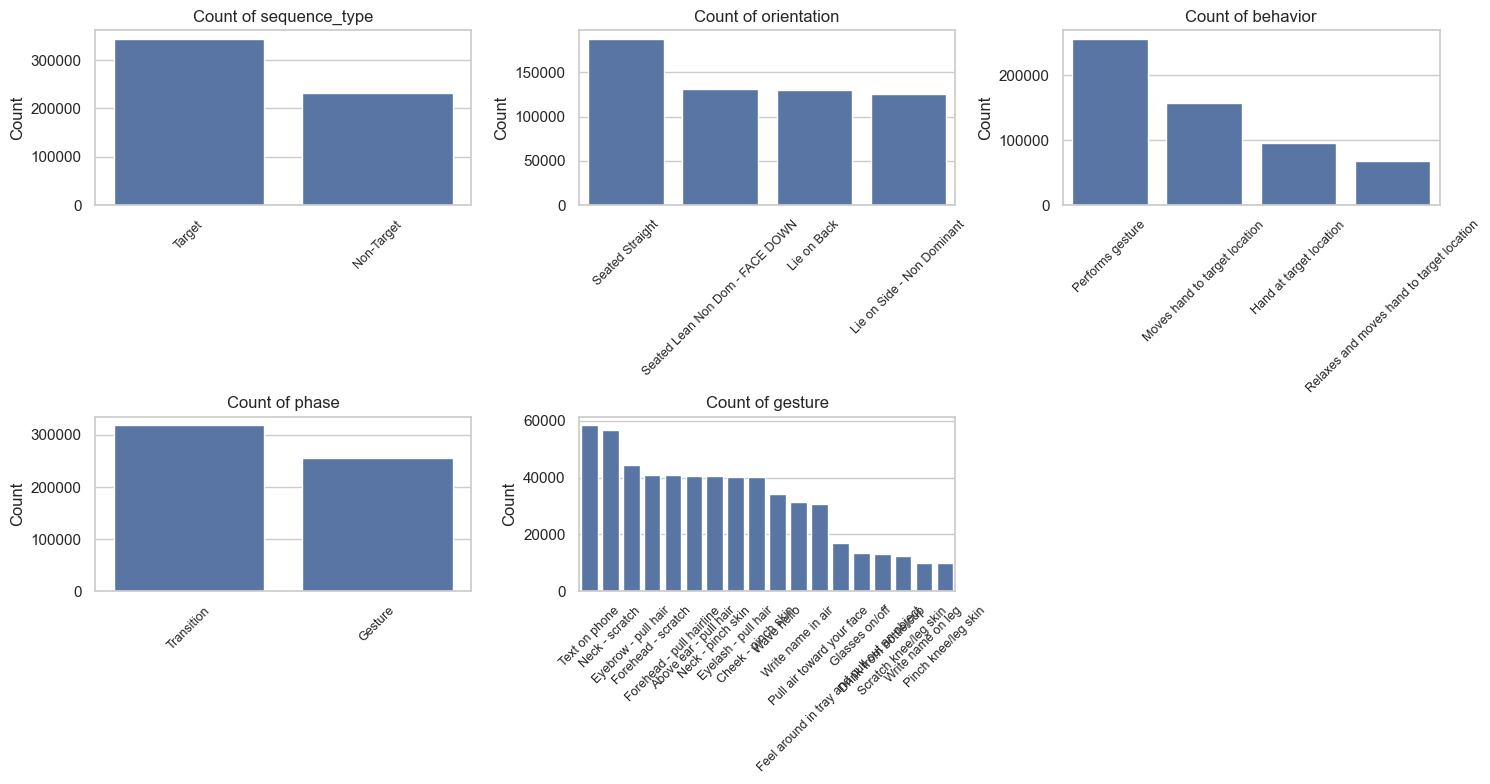

In [248]:
plot_object_counts(df_cat)

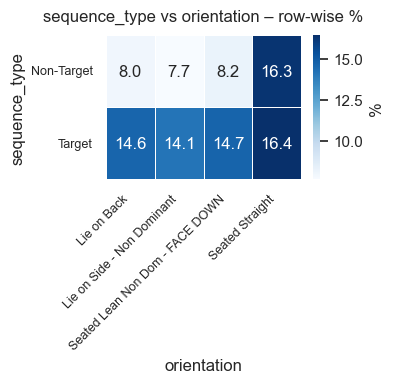

C:\Users\trfit\AppData\Local\Temp\ipykernel_9860\1664732135.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


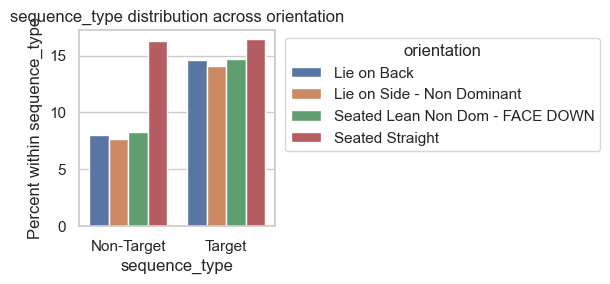

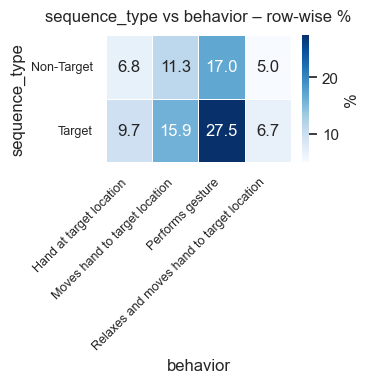

C:\Users\trfit\AppData\Local\Temp\ipykernel_9860\1664732135.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


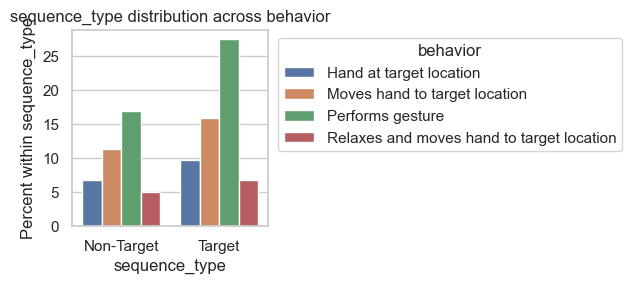

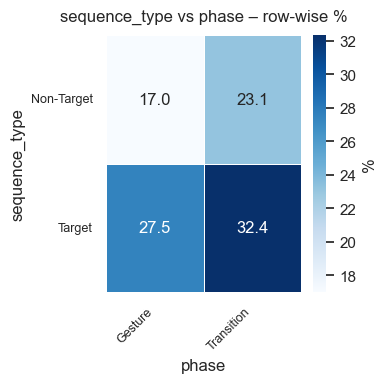

C:\Users\trfit\AppData\Local\Temp\ipykernel_9860\1664732135.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


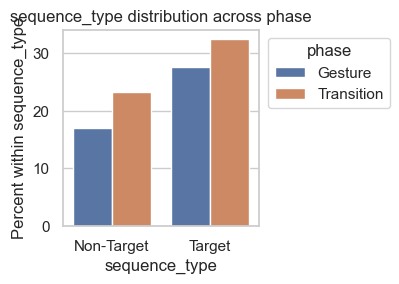

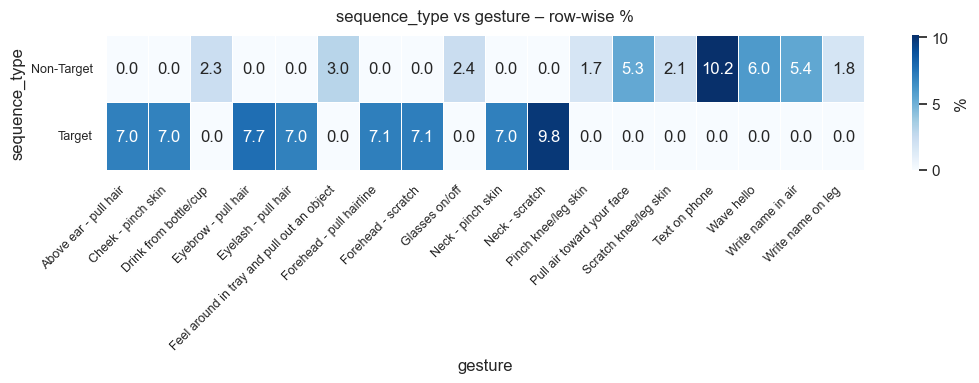

C:\Users\trfit\AppData\Local\Temp\ipykernel_9860\1664732135.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


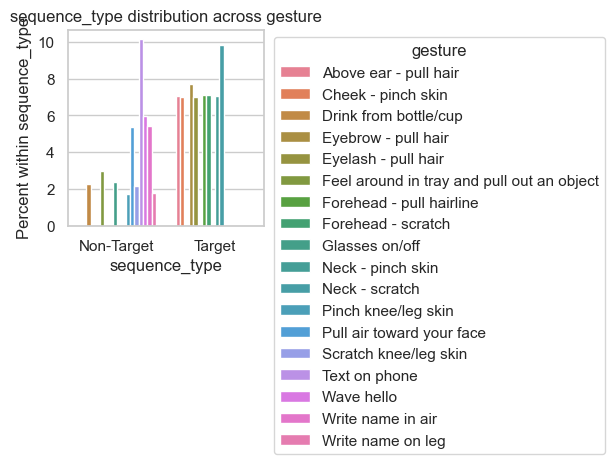

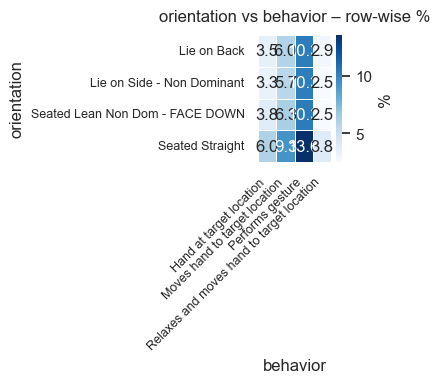

C:\Users\trfit\AppData\Local\Temp\ipykernel_9860\1664732135.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


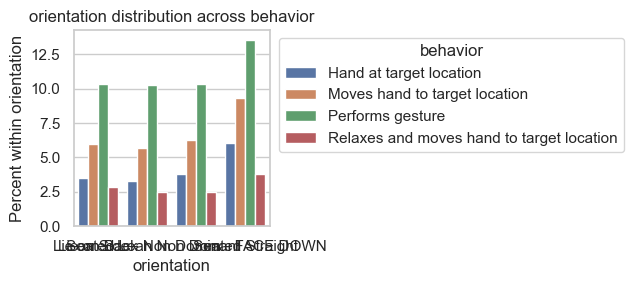

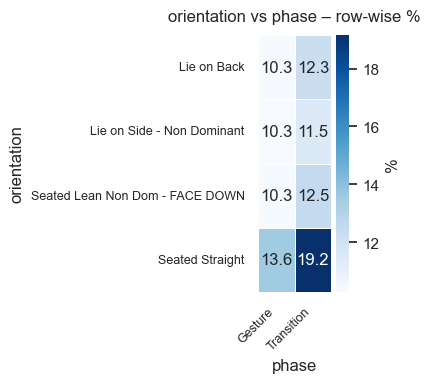

C:\Users\trfit\AppData\Local\Temp\ipykernel_9860\1664732135.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


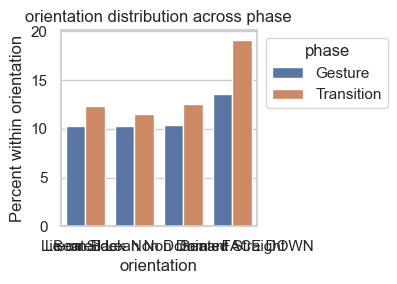

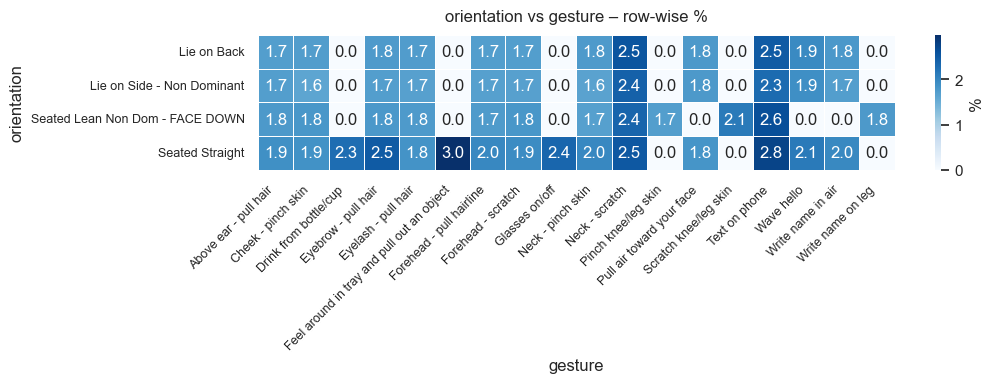

C:\Users\trfit\AppData\Local\Temp\ipykernel_9860\1664732135.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


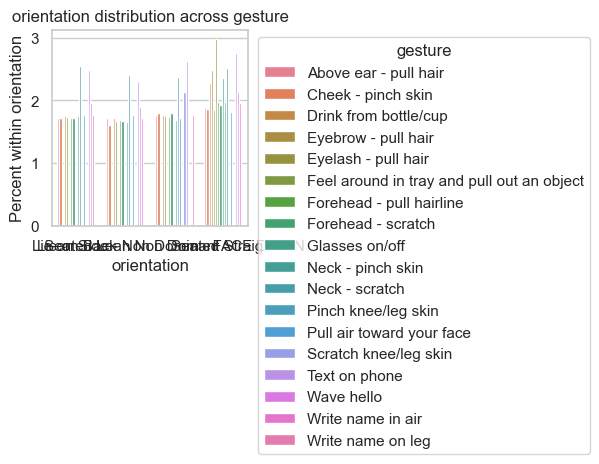

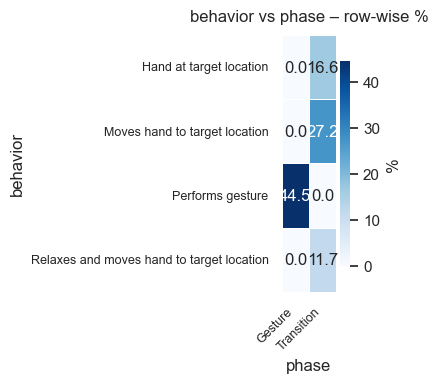

C:\Users\trfit\AppData\Local\Temp\ipykernel_9860\1664732135.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


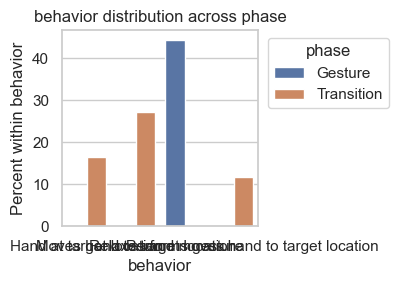

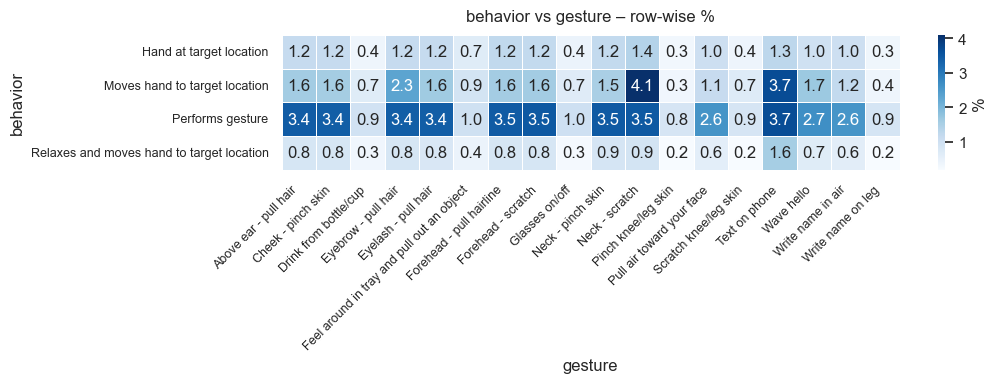

C:\Users\trfit\AppData\Local\Temp\ipykernel_9860\1664732135.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


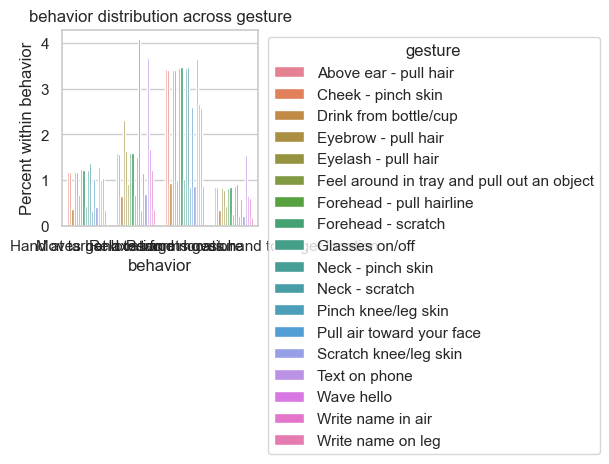

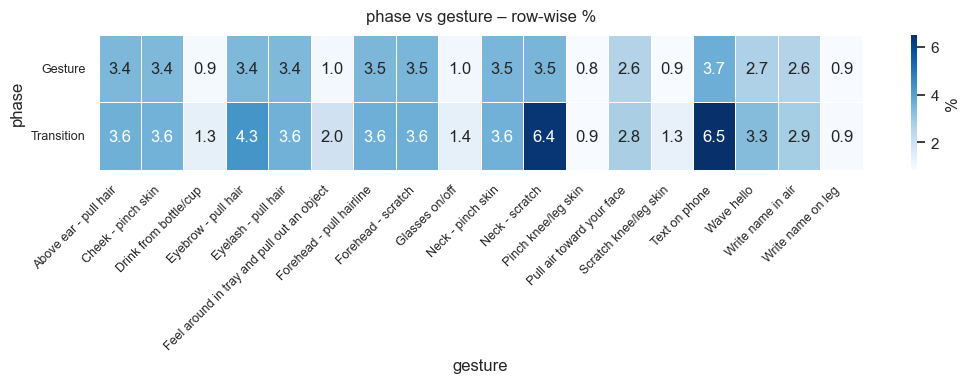

C:\Users\trfit\AppData\Local\Temp\ipykernel_9860\1664732135.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


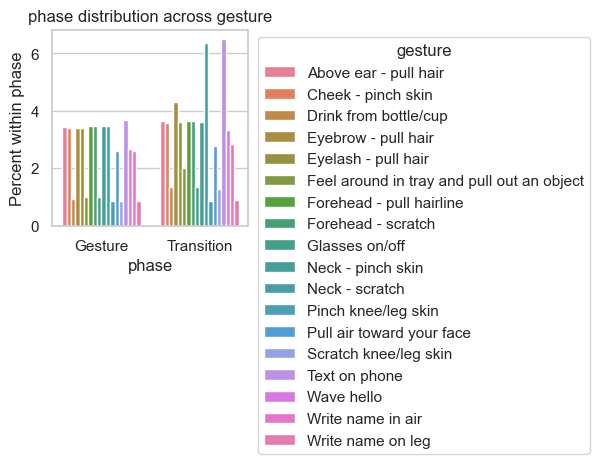

,X,Y,chi2,p
0,sequence_type,orientation,10773.806868,0.000000e+00
3,sequence_type,gesture,574945.000000,0.000000e+00
4,orientation,behavior,1710.326785,0.000000e+00
6,orientation,gesture,235936.643503,0.000000e+00
7,behavior,phase,574945.000000,0.000000e+00
8,behavior,gesture,16112.552948,0.000000e+00
9,phase,gesture,6983.916926,0.000000e+00
5,orientation,phase,1170.972407,1.455984e-253
1,sequence_type,behavior,751.190650,1.665003e-162
2,sequence_type,phase,722.642505,3.564948e-159


In [249]:
cat_cols = df_cat.select_dtypes("object").columns
results = []
for i, col_x in enumerate(cat_cols):
    for col_y in cat_cols[i+1:]:
        counts, percents = cross_summary(df_cat, col_x, col_y, normalize='all')
        
        chi2, p, *_ = chi2_contingency(counts)
        results.append({"X": col_x, "Y": col_y,
                        "chi2": chi2, "p": p})
        if p < 0.005 :
            heatmap_crosstab(percents, col_x, col_y)
            stacked = (
                percents
                  .reset_index()                       # now the col_x index becomes a column
                  .melt(id_vars=col_x,                 # ...and melt can see it
                        var_name=col_y,
                        value_name="percent")
            )
            g = sns.barplot(data=stacked, x=col_x, y="percent", hue=col_y)
            g.set_ylabel(f"Percent within {col_x}")
            g.set_title(f"{col_x} distribution across {col_y}")
            plt.legend(title=col_y, bbox_to_anchor=(1.01, 1), loc="upper left")
            plt.tight_layout()
            plt.show()
            

chi_df = pd.DataFrame(results).sort_values("p")
display(chi_df)

# Scratch Pad: 
Everything above this line block should be kept. Everything below is testing and temporary.

In [251]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def grid_hists(
    df: pd.DataFrame,
    cols: list[str],
    *,
    bins: int         = 30,
    kde: bool         = True,
    max_cols: int     = 3,          # ≤ plots per row
    figsize_per_plot: tuple[int,int] = (4, 3),
    color: str        = "steelblue",
    edge_kw: dict     = None
):
    """
    Plot multiple histograms in a single grid.

    Parameters
    ----------
    df   : DataFrame containing your data
    cols : list of column names to plot
    bins : number of histogram bins
    kde  : overlay kernel density curve?
    max_cols : max panels per row before wrapping
    figsize_per_plot : (width, height) of each subplot in inches
    color : fill colour for bars
    edge_kw : dict for bar outlines, e.g., dict(linewidth=.4, edgecolor="0.4")
    """
    edge_kw = edge_kw or dict(linewidth=.4, edgecolor="0.4")

    n_plots = len(cols)
    n_cols  = min(max_cols, n_plots)
    n_rows  = math.ceil(n_plots / n_cols)

    w, h    = figsize_per_plot
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(w * n_cols, h * n_rows),
        squeeze=False,
    )

    sns.set_theme(style="whitegrid")

    for ax, col in zip(axes.flat, cols):
        sns.histplot(
            data=df, x=col, bins=bins, kde=kde,
            color=color, ax=ax, **edge_kw
        )
        ax.set_title(col, fontsize=10)
        ax.set_xlabel("")                 # cleaner; title suffices
        ax.set_ylabel("Count")
        # Optionally annotate range & skew
        rng  = df[col].agg(['min','max'])
        skew = df[col].skew()
        ax.annotate(f"min={rng['min']:.2f}\nmax={rng['max']:.2f}\nskew={skew:.2f}",
                    xy=(0.97, 0.97), xycoords="axes fraction",
                    ha="right", va="top", fontsize=8,
                    bbox=dict(boxstyle="round,pad=.2", fc="white", alpha=.7))

    # Hide any unused axes slots
    for ax in axes.flat[n_plots:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()


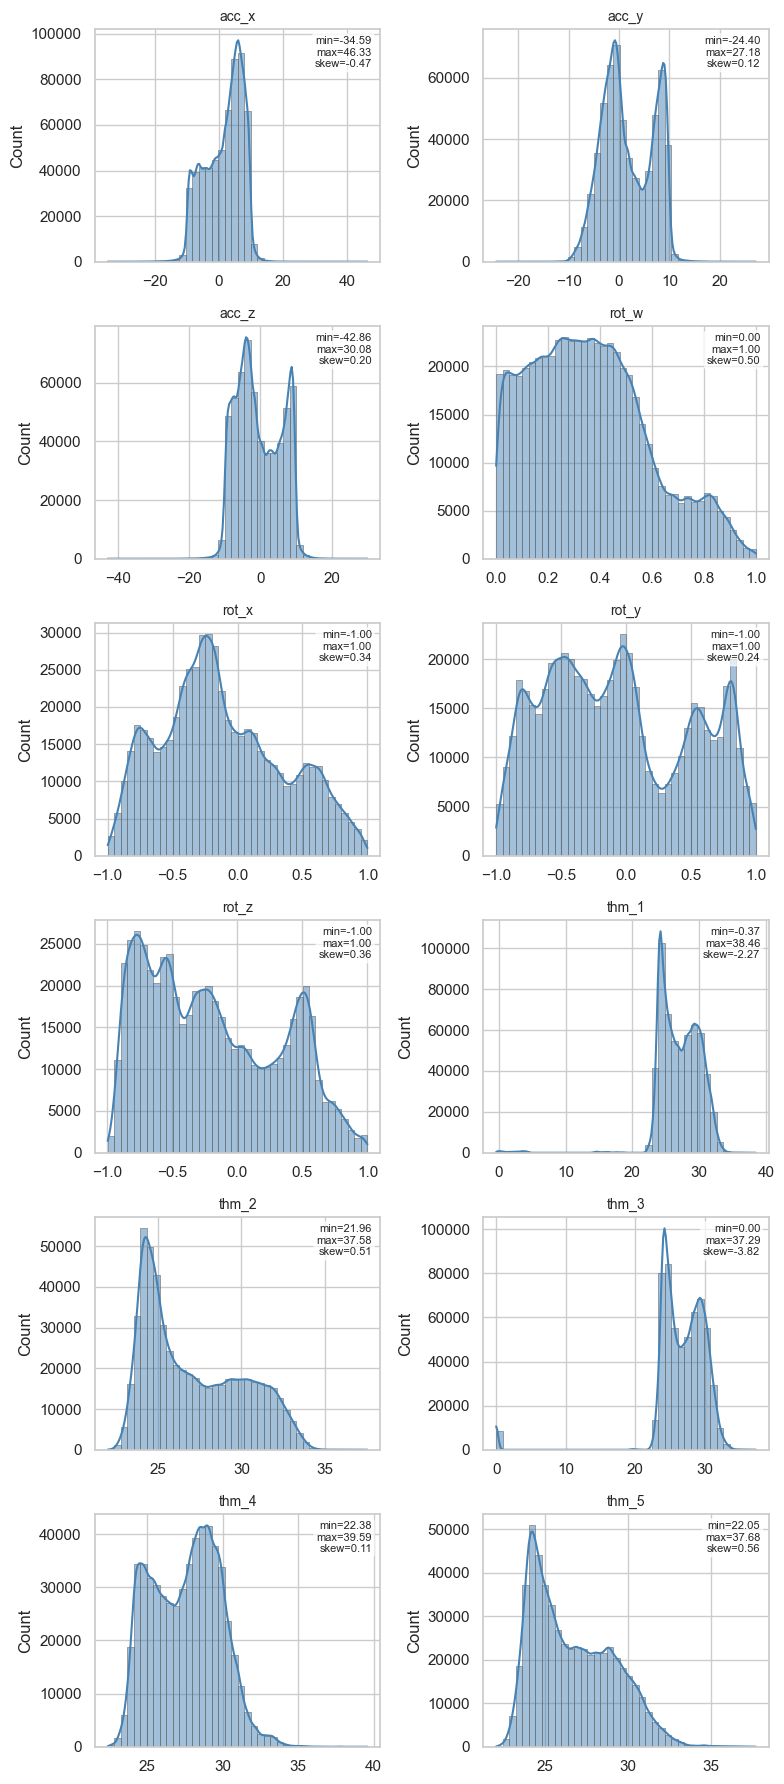

In [258]:

sensor_num = "1"
numeric_cols = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5']
grid_hists(df_train, numeric_cols, bins=40, max_cols=2)

    PC  Explained %  Cumulative %
0  PC1        46.18         46.18
1  PC2        29.17         75.35
2  PC3        24.65        100.00


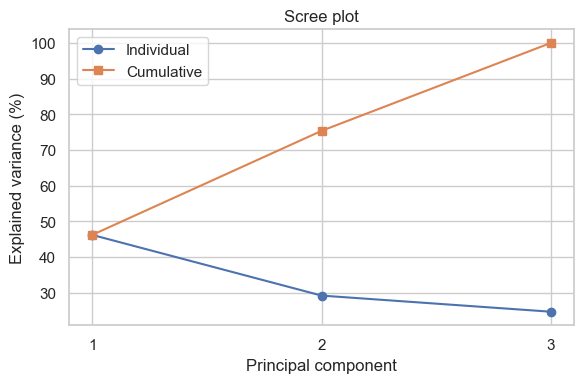


Loadings (coefficients):



,PC1,PC2,PC3
acc_x,0.563,0.641,-0.521
acc_y,-0.530,0.764,0.368
acc_z,0.634,0.069,0.770


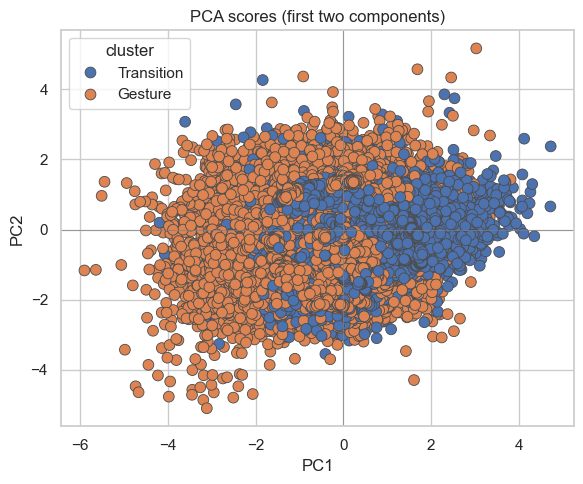

In [268]:
# --- 0. Imports -----------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set_theme(style="whitegrid")

# --- 1. Pick the numerical columns ---------------------------------------
num_cols =  ['acc_x', 'acc_y', 'acc_z'] 
    #'rot_w', 'rot_x', 'rot_y', 'rot_z'] 
    #'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5']
X = df_train[num_cols].dropna().copy()     # drop rows w/ missing nums (or impute!)

# --- 2. Standardise (μ=0, σ=1) -------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Run PCA -----------------------------------------------------------
pca = PCA()                          # keep all comps; slice later
X_pca = pca.fit_transform(X_scaled)

# --- 4. Explained variance -----------------------------------------------
evr = pca.explained_variance_ratio_          # as fraction
evr_cum = np.cumsum(evr)

print(pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(evr))],
    "Explained %": evr * 100,
    "Cumulative %": evr_cum * 100
}).round(2))

# Scree plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(evr)+1), evr*100, marker="o", label="Individual")
plt.plot(range(1, len(evr)+1), evr_cum*100, marker="s", label="Cumulative")
plt.xticks(range(1, len(evr)+1))
plt.ylabel("Explained variance (%)")
plt.xlabel("Principal component")
plt.title("Scree plot")
plt.legend()
plt.tight_layout()
plt.show()

# --- 5. Loadings (variable ↔ PC weight) -----------------------------------
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(len(evr))],
    index=num_cols
)
print("\nLoadings (coefficients):\n")
display(loadings.round(3))

# --- 6. (Optional) 2-D scores scatter ------------------------------------
# Pick first two PCs
scores = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"])
scores["cluster"] = df_train.loc[X.index, "phase"]  # <- colour by cat

plt.figure(figsize=(6,5))
sns.scatterplot(data=scores, x="PC1", y="PC2", hue="cluster", s=60, edgecolor="0.3")
plt.axhline(0, lw=.5, c="grey"); plt.axvline(0, lw=.5, c="grey")
plt.title("PCA scores (first two components)")
plt.tight_layout()
plt.show()


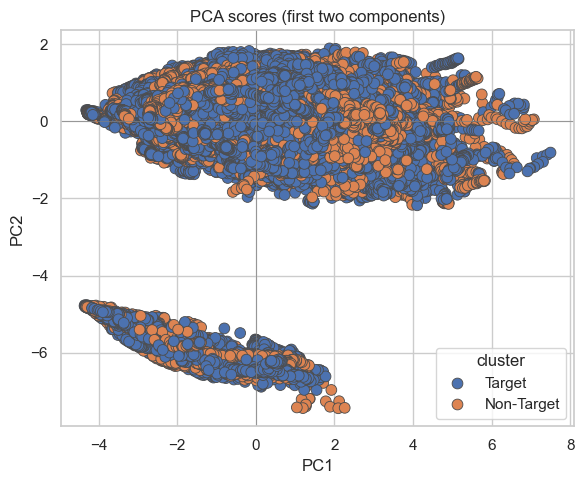

C:\Users\trfit\AppData\Local\Temp\ipykernel_9860\1407722045.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\trfit\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


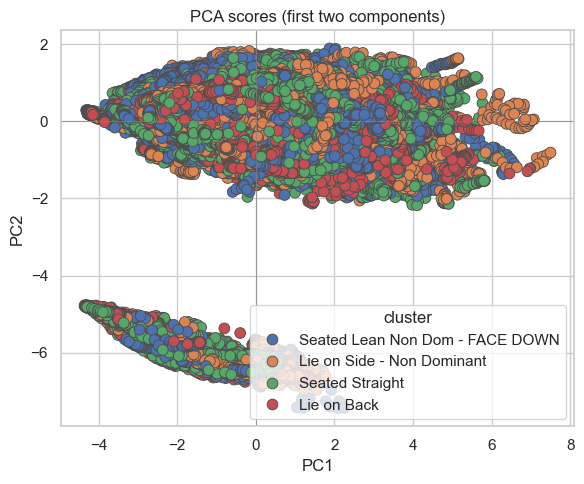

C:\Users\trfit\AppData\Local\Temp\ipykernel_9860\1407722045.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\trfit\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


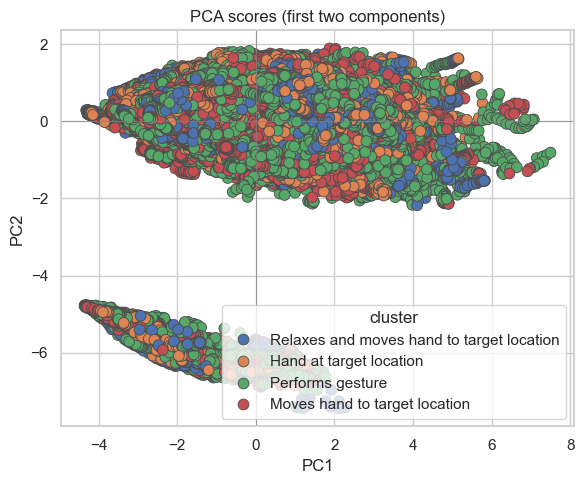

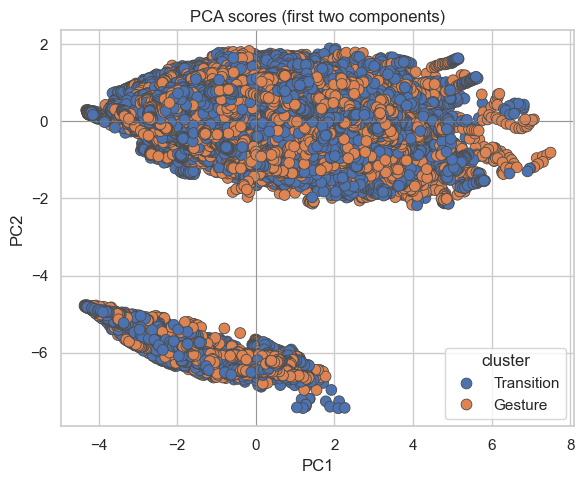

C:\Users\trfit\AppData\Local\Temp\ipykernel_9860\1407722045.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\trfit\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


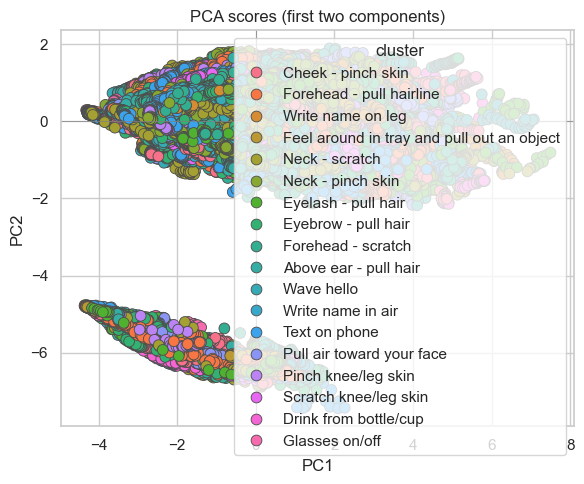

In [265]:
for cat in ['sequence_type', 'orientation','behavior','phase','gesture']:
    scores = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"])
    scores["cluster"] = df_train.loc[X.index, cat]  # <- colour by cat
    
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=scores, x="PC1", y="PC2", hue="cluster", s=60, edgecolor="0.3")
    plt.axhline(0, lw=.5, c="grey"); plt.axvline(0, lw=.5, c="grey")
    plt.title("PCA scores (first two components)")
    plt.tight_layout()
    plt.show()